In [99]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
# Algorithms for comparison
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from warnings import filterwarnings
filterwarnings('ignore')

In [100]:
#load dataset
df=pd.read_csv('dengue_features_train.csv')
labels = pd.read_csv('dengue_labels_train.csv')
test = pd.read_csv('dengue_features_test.csv')
#fill NaNs
df.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)
#to datetime
df['week_start_date']=pd.to_datetime(df['week_start_date'])
test['week_start_date']=pd.to_datetime(test['week_start_date'])
#extract month to new column
df['month']=df.week_start_date.dt.month
test['month']=test.week_start_date.dt.month

In [101]:
df.shape

(1456, 25)

In [102]:
df=pd.merge(df, labels, on=['city', 'year', 'weekofyear'])

In [103]:
cols_to_lag=[
 'ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_precip_mm',
 ]

In [104]:
for col in cols_to_lag:
    df['lagged_'+col] = df[col].shift(2)

for col in cols_to_lag:
    test['lagged_'+col] = test[col].shift(2)

In [105]:
lagged_cols=[
    #'month',
 'lagged_ndvi_ne',
 'lagged_ndvi_nw',
 'lagged_ndvi_se',
 'lagged_ndvi_sw',
 'lagged_precipitation_amt_mm',
 'lagged_reanalysis_air_temp_k',
 'lagged_reanalysis_avg_temp_k',
 'lagged_reanalysis_dew_point_temp_k',
 'lagged_reanalysis_max_air_temp_k',
 'lagged_reanalysis_min_air_temp_k',
 'lagged_reanalysis_precip_amt_kg_per_m2',
 'lagged_reanalysis_relative_humidity_percent',
 'lagged_reanalysis_sat_precip_amt_mm',
 'lagged_reanalysis_specific_humidity_g_per_kg',
 'lagged_reanalysis_tdtr_k',
 'lagged_station_precip_mm',
 'total_cases'
]

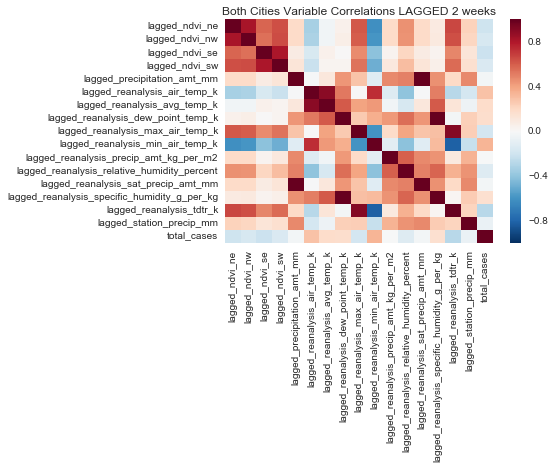

In [106]:
import seaborn as sns
# compute the correlations
correlations = df[lagged_cols].corr()
corr_heat = sns.heatmap(correlations)
plt.title('Both Cities Variable Correlations LAGGED 2 weeks')

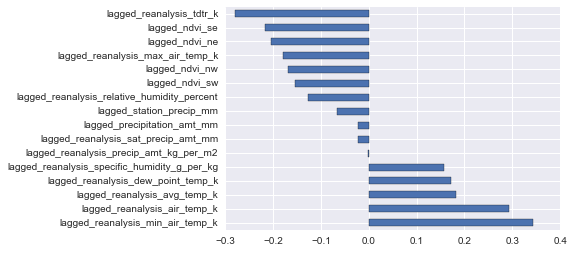

In [107]:
# both cities
(correlations
     .total_cases
     .drop('total_cases') # don't compare with itself
     .sort_values(ascending=False)
     .plot
     .barh())

In [108]:
(correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False))

lagged_reanalysis_min_air_temp_k                0.342550
lagged_reanalysis_air_temp_k                    0.293833
lagged_reanalysis_avg_temp_k                    0.181701
lagged_reanalysis_dew_point_temp_k              0.172234
lagged_reanalysis_specific_humidity_g_per_kg    0.158217
lagged_reanalysis_precip_amt_kg_per_m2         -0.001245
lagged_reanalysis_sat_precip_amt_mm            -0.023558
lagged_precipitation_amt_mm                    -0.023558
lagged_station_precip_mm                       -0.066913
lagged_reanalysis_relative_humidity_percent    -0.127608
lagged_ndvi_sw                                 -0.153587
lagged_ndvi_nw                                 -0.169623
lagged_reanalysis_max_air_temp_k               -0.180101
lagged_ndvi_ne                                 -0.203968
lagged_ndvi_se                                 -0.216790
lagged_reanalysis_tdtr_k                       -0.279558
Name: total_cases, dtype: float64

In [293]:
iq.total_cases.describe()

count    520.000000
mean       7.565385
std       10.765478
min        0.000000
25%        1.000000
50%        5.000000
75%        9.000000
max      116.000000
Name: total_cases, dtype: float64

In [294]:
sj.total_cases.describe()

count    933.000000
mean      34.276527
std       51.436037
min        0.000000
25%        9.000000
50%       19.000000
75%       37.000000
max      461.000000
Name: total_cases, dtype: float64

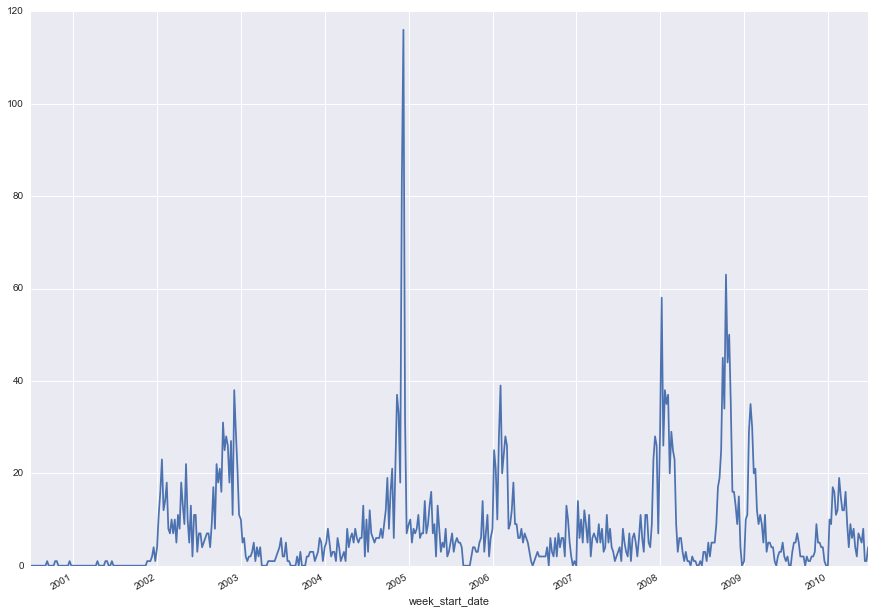

In [291]:
f, ax = plt.subplots(figsize=(15,11))
iq.total_cases.plot()

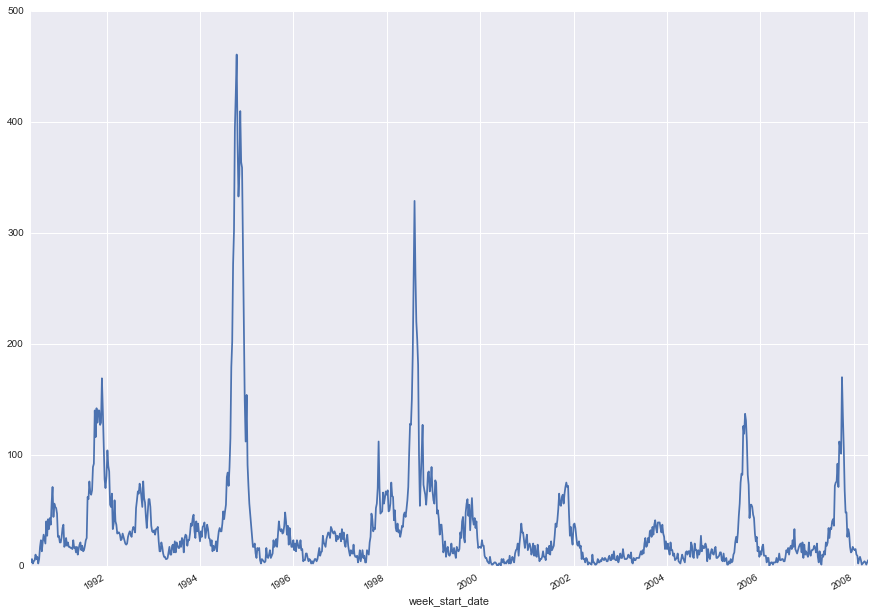

In [290]:
f, ax = plt.subplots(figsize=(15,11))
sj.total_cases.plot()

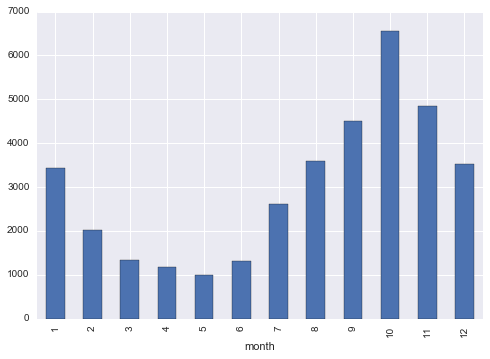

In [91]:
df.groupby(['month']).total_cases.sum().plot(kind='bar')
#the month of year should also matter bc of seasonality effect

In [95]:
# separate san juan and iquitos
sj = df[df['city']=='sj']
iq = df[df['city']=='iq']

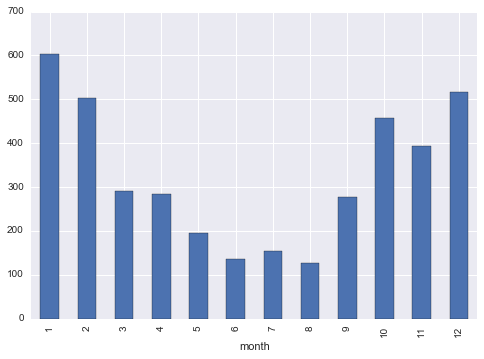

In [97]:
iq.groupby(['month']).total_cases.sum().plot(kind='bar')

In [112]:
# use the top correlated vars as the features cols for the model analysis

feature_cols=[
    'lagged_reanalysis_min_air_temp_k',
    'month',
    'lagged_reanalysis_air_temp_k',
    'lagged_reanalysis_avg_temp_k',
    'lagged_reanalysis_dew_point_temp_k',
    'lagged_reanalysis_specific_humidity_g_per_kg'   
]

In [110]:
sj.dropna(inplace=True)
iq.dropna(inplace=True)

LR: -28.513134 (14.319544)
DT: -35.905525 (13.886454)
RFR: -30.349845 (13.036078)
SVR: -22.743584 (18.142569)


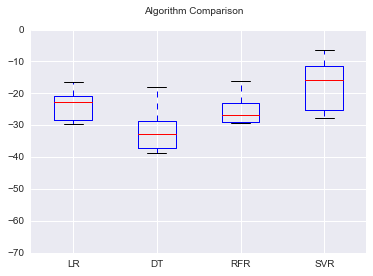

In [113]:
#code reference
#set x and y
X= sj[feature_cols]
Y = sj['total_cases']

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', linear_model.LinearRegression()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('SVR', SVR()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring='neg_mean_absolute_error')
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

LR: -6.886179 (1.867785)
DT: -9.126923 (1.523095)
RFR: -7.857063 (1.963210)
SVR: -6.120242 (2.623829)


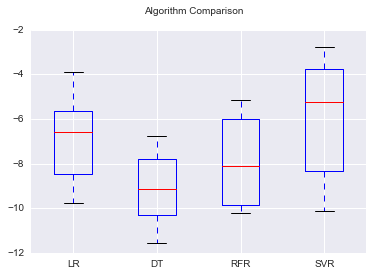

In [114]:
#code reference
#set x and y
X= iq[feature_cols]
Y = iq['total_cases']

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('LR', linear_model.LinearRegression()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('SVR', SVR()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring='neg_mean_absolute_error')
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [23]:
#support vector regressor appears to be the best in both cases

In [24]:
#use DT to look at features importances, for curiosity sake ha

In [132]:
test.replace([np.inf, -np.inf], np.nan)
test.fillna(method='bfill', inplace=True)
test.fillna(method='bfill', inplace=True)

df.replace([np.inf, -np.inf], np.nan)
df.fillna(method='bfill', inplace=True)
df.fillna(method='bfill', inplace=True)

In [133]:
X= df[feature_cols]
Y = df['total_cases']

model =DecisionTreeRegressor()
model.fit(X,Y)
model.predict(test[feature_cols])

importances=model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 0 (0.223957)
2. feature 1 (0.223173)
3. feature 5 (0.212936)
4. feature 3 (0.161389)
5. feature 4 (0.123331)
6. feature 2 (0.055213)


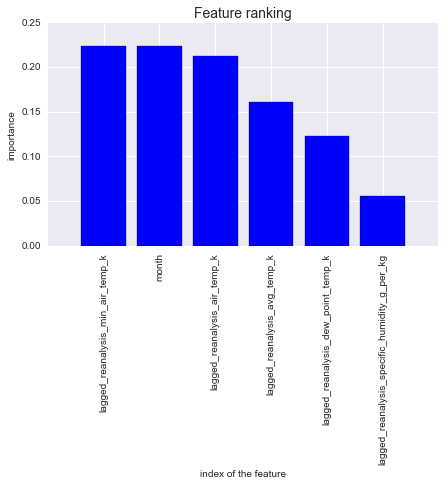

In [134]:
X= df[feature_cols]
Y = df['total_cases']

model =DecisionTreeRegressor()
model.fit(X,Y)
model.predict(test[feature_cols])

importances=model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

feature_names = X.columns

f, ax = plt.subplots(figsize=(7, 4))
plt.title("Feature ranking", fontsize = 14)
plt.bar(range(X.shape[1]), importances[indices],
    color="b", 
    align="center")
plt.xticks(range(X.shape[1]), feature_names, rotation=90 )
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 10)
plt.xlabel("index of the feature", fontsize = 10)

In [142]:
most_cols=[
 'month',
 'lagged_ndvi_ne',
 'lagged_ndvi_nw',
 'lagged_ndvi_se',
 'lagged_ndvi_sw',
 'lagged_precipitation_amt_mm',
 'lagged_reanalysis_air_temp_k',
 'lagged_reanalysis_avg_temp_k',
 'lagged_reanalysis_dew_point_temp_k',
 'lagged_reanalysis_max_air_temp_k',
 'lagged_reanalysis_min_air_temp_k',
 'lagged_reanalysis_precip_amt_kg_per_m2',
 'lagged_reanalysis_relative_humidity_percent',
 'lagged_reanalysis_sat_precip_amt_mm',
 'lagged_reanalysis_specific_humidity_g_per_kg',
 'lagged_reanalysis_tdtr_k',
 'lagged_station_precip_mm'
]

In [145]:
X= df[most_cols]
Y = df['total_cases']

model =DecisionTreeRegressor()
model.fit(X,Y)
model.predict(test[most_cols])

importances=model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 3 (0.420344)
2. feature 10 (0.141430)
3. feature 14 (0.058712)
4. feature 0 (0.047860)
5. feature 7 (0.043902)
6. feature 1 (0.043317)
7. feature 16 (0.035658)
8. feature 8 (0.033890)
9. feature 15 (0.028095)
10. feature 11 (0.026567)
11. feature 2 (0.023567)
12. feature 6 (0.023150)
13. feature 5 (0.022104)
14. feature 4 (0.021063)
15. feature 9 (0.015054)
16. feature 12 (0.012451)
17. feature 13 (0.002835)


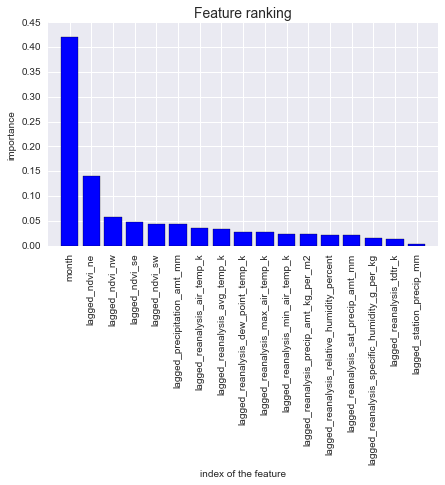

In [147]:
feature_names = X.columns

f, ax = plt.subplots(figsize=(7, 4))
plt.title("Feature ranking", fontsize = 14)
plt.bar(range(X.shape[1]), importances[indices],
    color="b", 
    align="center")
plt.xticks(range(X.shape[1]), feature_names, rotation=90 )
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 10)
plt.xlabel("index of the feature", fontsize = 10)

### gridsearch SVR

In [161]:
from sklearn.model_selection import GridSearchCV
import time as time

In [266]:
sj_train_subtrain = sj.head(800)
sj_train_subtest = sj.tail(sj.shape[0] - 800)

iq_train_subtrain = iq.head(400)
iq_train_subtest = iq.tail(iq.shape[0] - 400)

In [267]:
X= df[feature_cols]
Y = df['total_cases']

In [268]:
train_size = 100
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

t0 = time.time()
svr.fit(X,Y)
svr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s"
      % svr_fit)

SVR complexity and bandwidth selected and model fitted in 21.328 s


In [269]:
model_svr=svr.best_estimator_

In [270]:
preds_sj_svr= model.predict(sj_train_subtest[feature_cols]).astype(int)
preds_iq_svr=model.predict(iq_train_subtest[feature_cols]).astype(int)

In [271]:
sj_train_subtest['fitted'] = preds_sj_svr
iq_train_subtest['fitted'] = preds_iq_svr

In [250]:
### reset axis
sj_train_subtest.index = sj_train_subtest['week_start_date']
iq_train_subtest.index = iq_train_subtest['week_start_date']


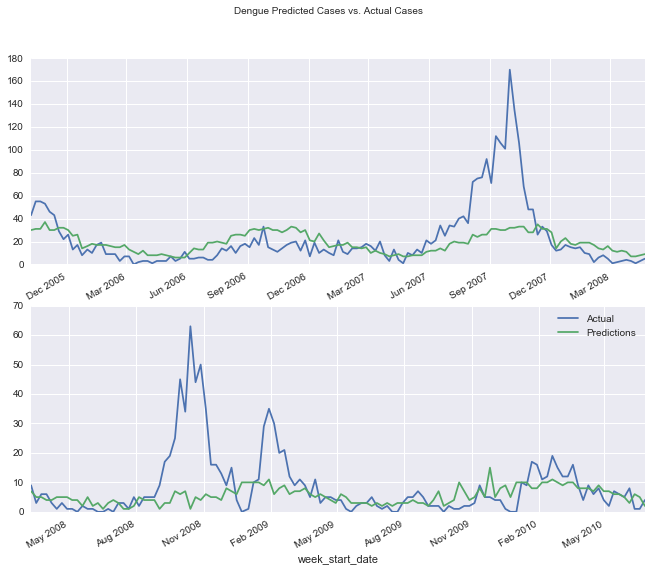

In [251]:
figs, axes = plt.subplots(nrows=2, ncols=1, figsize=(11, 9))
sj_train_subtest.total_cases.plot(ax=axes[0], label="Actual")
sj_train_subtest.fitted.plot(ax=axes[0], label="Predictions")

iq_train_subtest.total_cases.plot(ax=axes[1], label="Actual")
iq_train_subtest.fitted.plot(ax=axes[1], label="Predictions")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

### gridsearch GLM 

In [257]:
sj_train_subtrain = sj.head(800)
sj_train_subtest = sj.tail(sj.shape[0] - 800)

iq_train_subtrain = iq.head(400)
iq_train_subtest = iq.tail(iq.shape[0] - 400)

In [258]:
import statsmodels.api as sm
from statsmodels.tools import eval_measures
import statsmodels.formula.api as smf

def get_best_model(train, test):
    # Step 1: specify the form of the model
    model_formula = "total_cases ~ 1 + " \
                    'lagged_reanalysis_min_air_temp_k +'\
                    'month +'\
                    'lagged_reanalysis_air_temp_k +'\
                    'lagged_reanalysis_avg_temp_k +'\
                    'lagged_reanalysis_dew_point_temp_k +'\
                    'lagged_reanalysis_specific_humidity_g_per_kg'  
                    
    
    grid = 10 ** np.arange(-8, -3, dtype=np.float64)
                    
    best_alpha = []
    best_score = 1000
        
    # Step 2: Find the best hyper parameter, alpha
    for alpha in grid:
        model = smf.glm(formula=model_formula, data=df, family=sm.families.NegativeBinomial(alpha=alpha))

        results = model.fit()
        predictions = results.predict(test).astype(int)
        score = eval_measures.meanabs(predictions, test.total_cases)

        if score < best_score:
            best_alpha = alpha
            best_score = score

    print('best alpha = ', best_alpha)
    print('best score = ', best_score)
            
    # Step 3: refit on entire dataset
    full_dataset = pd.concat([train, test])
    model = smf.glm(formula=model_formula,
                    data=full_dataset,
                    family=sm.families.NegativeBinomial(alpha=best_alpha))

    fitted_model = model.fit()
    return fitted_model
    
sj_best_model = get_best_model(sj_train_subtrain, sj_train_subtest)
iq_best_model = get_best_model(iq_train_subtrain, iq_train_subtest)

best alpha =  1e-08
best score =  20.0977443609
best alpha =  1e-08
best score =  7.825


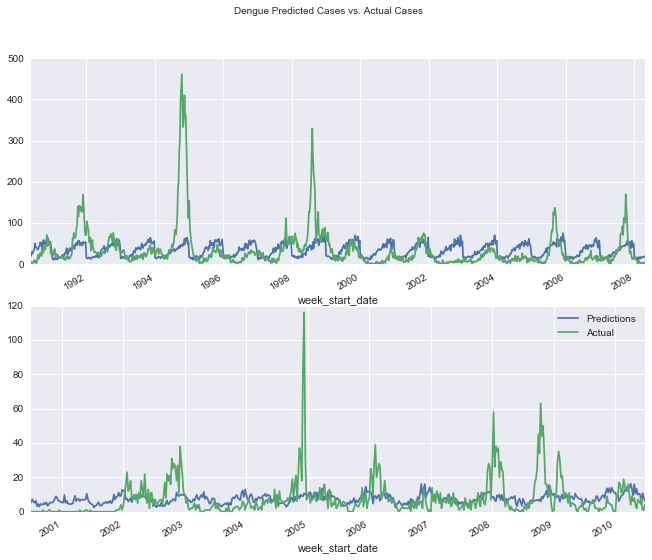

In [259]:
figs, axes = plt.subplots(nrows=2, ncols=1, figsize=(11, 9))

# plot sj
sj['fitted'] = sj_best_model.fittedvalues
sj.fitted.plot(ax=axes[0], label="Predictions")
sj.total_cases.plot(ax=axes[0], label="Actual")

# plot iq
iq['fitted'] = iq_best_model.fittedvalues
iq.fitted.plot(ax=axes[1], label="Predictions")
iq.total_cases.plot(ax=axes[1], label="Actual")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

In [106]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([predictions])
submission.to_csv("submissions/benchmark4.csv")

### clearly the model is unable to predict the spikes in disease outbreak
#### I need to somehow account for the cases in previous weeks - either true or predicted

In [265]:
#add feature for avg total cases in past month? 2 weeks?
df['2wk_avg_count']=(pd.rolling_mean(df['total_cases'], window=2))
df['4wk_avg_count']=(pd.rolling_mean(df['total_cases'], window=4))

In [264]:
df[['2wk_avg_count','total_cases']].head()

,2wk_avg_count,total_cases
0,NaN,4
1,4.5,5
2,4.5,4
3,3.5,3
4,4.5,6


In [ ]:
sj_train_subtrain = sj.head(800)
sj_train_subtest = sj.tail(sj.shape[0] - 800)

iq_train_subtrain = iq.head(400)
iq_train_subtest = iq.tail(iq.shape[0] - 400)

In [272]:
preds_sj_svr= model.predict(sj_train_subtest[feature_cols]).astype(int)
preds_iq_svr=model.predict(iq_train_subtest[feature_cols]).astype(int)

In [333]:
sj_train_subtest['fitted'] = preds_sj_svr
iq_train_subtest['fitted'] = preds_iq_svr

In [340]:
sj_train_subtest.head(100)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,rolling1mo_avgreanalysis_relative_humidity_percent,rolling1mo_avgreanalysis_sat_precip_amt_mm,rolling1mo_avgreanalysis_specific_humidity_g_per_kg,rolling1mo_avgreanalysis_tdtr_k,rolling1mo_avgstation_precip_mm,total_cases,fitted,2wk_avg_count,4wk_avg_count,total_fitted
week_start_date,,,,,,,,,,,,,,,,,,,,,
2005-10-08,sj,2005,40,2005-10-08,0.048800,0.039400,0.112557,0.077243,68.31,301.090000,...,77.842143,53.9000,18.787143,3.296429,28.625,43,30,NaN,NaN,13
2005-10-15,sj,2005,41,2005-10-15,0.041900,0.027933,0.055150,0.042443,157.83,299.834286,...,79.090000,82.4650,18.436071,3.085714,45.100,55,31,30.5,NaN,24
2005-10-22,sj,2005,42,2005-10-22,0.022750,0.027800,0.240357,0.204343,112.16,300.624286,...,80.522143,93.7900,18.549286,2.925000,52.700,55,31,31.0,NaN,24
2005-10-29,sj,2005,43,2005-10-29,-0.029975,0.051267,0.170557,0.162314,20.75,300.691429,...,81.357143,89.7625,18.621071,2.650000,61.525,53,37,34.0,32.25,16
2005-11-05,sj,2005,44,2005-11-05,0.075967,-0.062200,0.253514,0.201743,39.72,300.841429,...,81.511786,82.6150,18.581429,2.621429,71.175,46,30,33.5,32.25,16
2005-11-12,sj,2005,45,2005-11-12,-0.001350,0.064550,0.202214,0.152071,27.22,300.664286,...,80.777500,49.9625,18.629643,2.517857,47.575,43,30,30.0,32.00,13
2005-11-19,sj,2005,46,2005-11-19,0.050700,0.017400,0.200443,0.182171,37.36,299.971429,...,80.155357,31.2625,18.299643,2.350000,46.575,29,32,31.0,32.25,-3
2005-11-26,sj,2005,47,2005-11-26,0.050700,0.165400,0.215914,0.185229,14.49,299.467143,...,78.861071,29.6975,17.688929,2.385714,38.700,22,32,32.0,31.00,-10
2005-12-03,sj,2005,48,2005-12-03,0.050700,0.182300,0.268600,0.248186,26.65,299.182857,...,78.774643,26.4300,17.246786,2.346429,44.575,26,30,31.0,31.00,-4


In [339]:
sj_train_subtest['total_fitted']=sj_train_subtest['total_cases']-sj_train_subtest['fitted']

In [336]:
#add feature for avg total cases in past month? 2 weeks?
sj_train_subtest['2wk_avg_count']=(pd.rolling_mean(sj_train_subtest['fitted'], window=2))
sj_train_subtest['4wk_avg_count']=(pd.rolling_mean(sj_train_subtest['fitted'], window=4))
iq_train_subtest['2wk_avg_count']=(pd.rolling_mean(iq_train_subtest['fitted'], window=2))
iq_train_subtest['4wk_avg_count']=(pd.rolling_mean(iq_train_subtest['fitted'], window=4))

In [278]:
sj_train_subtest['fitted_plus_2']=(sj_train_subtest['fitted']+sj_train_subtest['2wk_avg_count'])/2
sj_train_subtest['fitted_plus_4']=sj_train_subtest['fitted']+sj_train_subtest['4wk_avg_count']
iq_train_subtest['fitted_plus_2']=iq_train_subtest['fitted']+iq_train_subtest['2wk_avg_count']
iq_train_subtest['fitted_plus_4']=iq_train_subtest['fitted']+iq_train_subtest['4wk_avg_count']

In [295]:
from sklearn.linear_model import BayesianRidge

In [ ]:
reg = linear_model.BayesianRidge()

In [296]:
sj_train_subtrain = sj.head(800)
sj_train_subtest = sj.tail(sj.shape[0] - 800)

iq_train_subtrain = iq.head(400)
iq_train_subtest = iq.tail(iq.shape[0] - 400)

In [297]:
X= df[feature_cols]
y = df['total_cases']

In [300]:
len(feature_cols)

6

In [311]:
w = np.zeros(6)
n_features =6
relevant_features = feature_cols

In [321]:
#clf = BayesianRidge(compute_score=True)
clf = linear_model.BayesianRidge(alpha_1=1e-08)
clf.fit(X, y)

BayesianRidge(alpha_1=1e-08, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [322]:
clf.coef_

array([ 3.97430184,  2.15529923,  7.08123073, -7.93927162,  0.54009716,
        0.86988149])

In [323]:
preds_sj_br= clf.predict(sj_train_subtest[feature_cols]).astype(int)
preds_iq_br=clf.predict(iq_train_subtest[feature_cols]).astype(int)

In [324]:
sj_train_subtest['fitted'] = preds_sj_br
iq_train_subtest['fitted'] = preds_iq_br

In [325]:
### reset axis
sj_train_subtest.index = sj_train_subtest['week_start_date']
iq_train_subtest.index = iq_train_subtest['week_start_date']

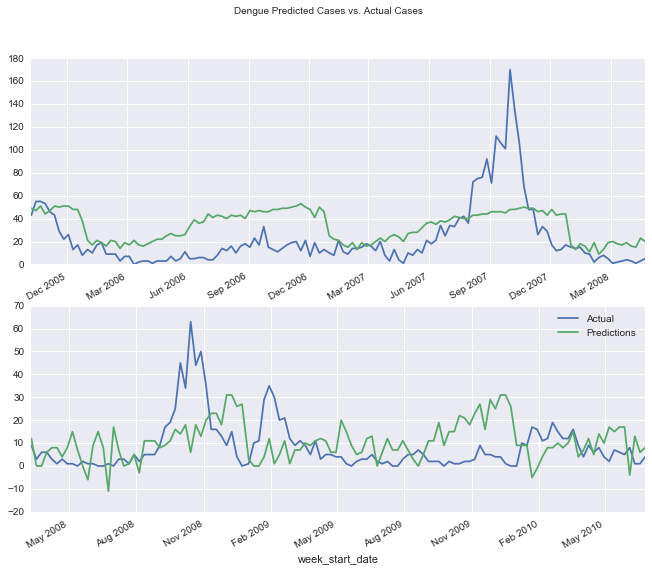

In [326]:
figs, axes = plt.subplots(nrows=2, ncols=1, figsize=(11, 9))
sj_train_subtest.total_cases.plot(ax=axes[0], label="Actual")
sj_train_subtest.fitted.plot(ax=axes[0], label="Predictions")

iq_train_subtest.total_cases.plot(ax=axes[1], label="Actual")
iq_train_subtest.fitted.plot(ax=axes[1], label="Predictions")

plt.suptitle("Dengue Predicted Cases vs. Actual Cases")
plt.legend()

In [328]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(sj_train_subtest.total_cases, sj_train_subtest.fitted)

20.556390977443609

In [331]:
predictions = clf.predict(test[feature_cols]).astype(int)

In [332]:
submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([predictions])
submission.to_csv("submissions/bayesian_ridge.csv")